In [4]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [25]:
#Get the stock quote 
df = web.DataReader('AIR', data_source='yahoo', start='2012-01-01', end='2020-08-01') 
#Take a look at the data 
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-27,18.480000,17.570000,18.150000,17.719999,330700.0,17.719999
2020-07-28,17.930000,17.129999,17.610001,17.139999,302100.0,17.139999
2020-07-29,17.510000,16.930000,17.200001,17.469999,253000.0,17.469999
2020-07-30,17.209999,16.570000,16.969999,16.780001,250700.0,16.780001
2020-07-31,17.290001,16.530001,16.730000,17.219999,335200.0,17.219999


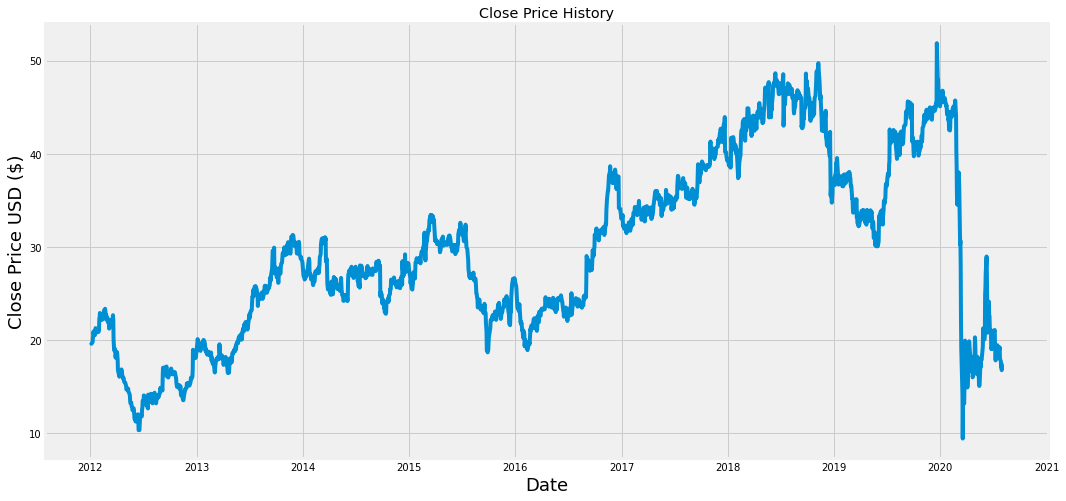

In [26]:
#Visualizing the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [27]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [29]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [30]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [31]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
#Train the model
model.fit(x_train, y_train, batch_size=50, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 29ms/step - loss: 0.0260
Epoch 2/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0018
Epoch 3/100
34/34 [==============================] - 1s 27ms/step - loss: 9.4604e-04
Epoch 4/100
34/34 [==============================] - 1s 28ms/step - loss: 9.3422e-04
Epoch 5/100
34/34 [==============================] - 1s 28ms/step - loss: 9.1055e-04
Epoch 6/100
34/34 [==============================] - 1s 28ms/step - loss: 8.9481e-04
Epoch 7/100
34/34 [==============================] - 1s 28ms/step - loss: 9.0498e-04
Epoch 8/100
34/34 [==============================] - 1s 28ms/step - loss: 8.2363e-04
Epoch 9/100
34/34 [==============================] - 1s 28ms/step - loss: 7.9347e-04
Epoch 10/100
34/34 [==============================] - 1s 28ms/step - loss: 7.7500e-04
Epoch 11/100
34/34 [==============================] - 1s 28ms/step - loss: 7.4940e-04
Epoch 12/100
34/34 [==============================] - 1s 28ms/step - lo

In [34]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])


#Convert x_test to a numpy array 
x_test = np.array(x_test)



#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [35]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [36]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.3266981066846006

C:\Users\kaart\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


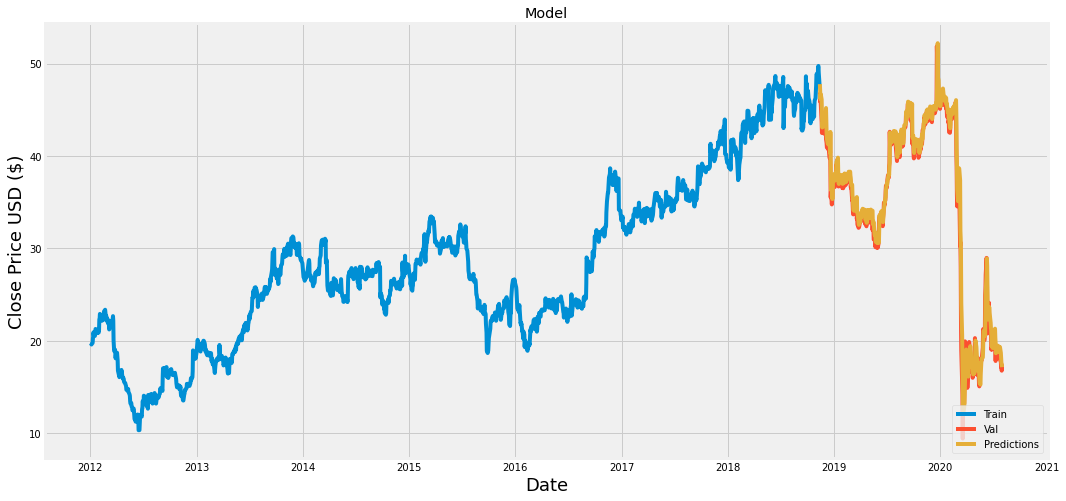

In [40]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('Air-NewZealand_Stock_price.png', dpi=100)
plt.show()